<a href="https://colab.research.google.com/github/moajjem04/Pytorch_Practice/blob/main/CNN_on_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is a colab code following the tutorial by [Jason Brownlee](https://machinelearningmastery.com/about/) named [**PyTorch Tutorial: How to Develop Deep Learning Models with Python**](https://machinelearningmastery.com/pytorch-tutorial-develop-deep-learning-models/). I will be specifically following the steps for CNN on MNIST data.

As explained in the tutorial, the process of deep learning consists of a cycle of:

1. Prepare the Data.
2. Define the Model.
3. Train the Model.
4. Evaluate the Model.
5. Make Predictions.

# 1. Prepare the Data

## Import Modules

In [1]:
from torch.utils.data       import DataLoader # for easier handling of data
from torchvision.datasets   import MNIST      # the dataset
from torchvision.transforms import Compose    # for preprocessing
from torchvision.transforms import ToTensor   # converts to tensor

import matplotlib.pyplot    as plt            # for visualisation
%matplotlib inline
import numpy                as np

## Downloading MNIST Data

In [2]:
# define location to save or load the dataset
path = '~/.torch/datasets/mnist'
# define the transforms to apply to the data
trans = Compose([ToTensor()])
# download and define the datasets
train = MNIST(path, train=True, download=True, transform=trans)
test = MNIST(path, train=False, download=True, transform=trans)
# define how to enumerate the datasets
train_dl = DataLoader(train, batch_size=32, shuffle=True)
test_dl = DataLoader(test, batch_size=32, shuffle=True)

Extracting /root/.torch/datasets/mnist/MNIST/raw/train-images-idx3-ubyte.gz to /root/.torch/datasets/mnist/MNIST/raw


Extracting /root/.torch/datasets/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to /root/.torch/datasets/mnist/MNIST/raw



Extracting /root/.torch/datasets/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to /root/.torch/datasets/mnist/MNIST/raw


Extracting /root/.torch/datasets/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to /root/.torch/datasets/mnist/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## Display a batch of image

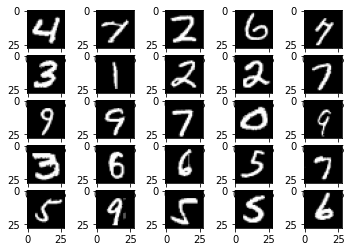

In [3]:
# get one batch of images
i, (inputs, targets) = next(enumerate(train_dl))
# plot some images
for i in range(25):
	# define subplot
	plt.subplot(5, 5, i+1)
	# plot raw pixel data
	plt.imshow(inputs[i][0], cmap='gray')

# show the figure
plt.show()

In [4]:
# Shape of Train and Test Dataset
print('Train Set:\n',train)
print('Test Set:\n',test)

Train Set:
 Dataset MNIST
    Number of datapoints: 60000
    Root location: /root/.torch/datasets/mnist
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )
Test Set:
 Dataset MNIST
    Number of datapoints: 10000
    Root location: /root/.torch/datasets/mnist
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
           )


# 2. Define the Model

In [5]:
from numpy import vstack
from numpy import argmax
from pandas import read_csv
from sklearn.metrics import accuracy_score
from torch.nn import Conv2d
from torch.nn import MaxPool2d
from torch.nn import Linear
from torch.nn import ReLU
from torch.nn import Softmax
from torch.nn import Module
from torch.optim import SGD
from torch.nn import CrossEntropyLoss
from torch.nn.init import kaiming_uniform_
from torch.nn.init import xavier_uniform_

In [6]:
# model definition
class CNN(Module):
    # define model elements
    def __init__(self, n_channels):
        super(CNN, self).__init__()
        # input to first hidden layer
        self.hidden1 = Conv2d(n_channels, 32, (3,3))
        kaiming_uniform_(self.hidden1.weight, nonlinearity='relu')
        self.act1 = ReLU()
        # first pooling layer
        self.pool1 = MaxPool2d((2,2), stride=(2,2))
        # second hidden layer
        self.hidden2 = Conv2d(32, 32, (3,3))
        kaiming_uniform_(self.hidden2.weight, nonlinearity='relu')
        self.act2 = ReLU()
        # second pooling layer
        self.pool2 = MaxPool2d((2,2), stride=(2,2))
        # fully connected layer
        self.hidden3 = Linear(5*5*32, 100)
        kaiming_uniform_(self.hidden3.weight, nonlinearity='relu')
        self.act3 = ReLU()
        # output layer
        self.hidden4 = Linear(100, 10)
        xavier_uniform_(self.hidden4.weight)
        self.act4 = Softmax(dim=1)
 
    # forward propagate input
    def forward(self, X):
        # input to first hidden layer
        X = self.hidden1(X)
        X = self.act1(X)
        X = self.pool1(X)
        # second hidden layer
        X = self.hidden2(X)
        X = self.act2(X)
        X = self.pool2(X)
        # flatten
        X = X.view(-1, 4*4*50)
        # third hidden layer
        X = self.hidden3(X)
        X = self.act3(X)
        # output layer
        X = self.hidden4(X)
        X = self.act4(X)
        return X

In [7]:
# define the network
model = CNN(1)
print(model)

CNN(
  (hidden1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (act1): ReLU()
  (pool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (hidden2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (act2): ReLU()
  (pool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (hidden3): Linear(in_features=800, out_features=100, bias=True)
  (act3): ReLU()
  (hidden4): Linear(in_features=100, out_features=10, bias=True)
  (act4): Softmax(dim=1)
)


# 3. Train the Model

In [8]:
from tqdm import tqdm

In [9]:
# train the model
def train_model(train_dl, model):
    # define the optimization
    criterion = CrossEntropyLoss()
    optimizer = SGD(model.parameters(), lr=0.01, momentum=0.9)
    # enumerate epochs
    for epoch in range(10):
        # enumerate mini batches
        for i, (inputs, targets) in tqdm(enumerate(train_dl)):
            # clear the gradients
            optimizer.zero_grad()
            # compute the model output
            yhat = model(inputs)
            # calculate loss
            loss = criterion(yhat, targets)
            # credit assignment
            loss.backward()
            # update model weights
            optimizer.step()

In [10]:
# # train the model
train_model(train_dl, model)

1875it [00:36, 51.22it/s]
1875it [00:36, 51.76it/s]
1875it [00:35, 52.10it/s]
1875it [00:35, 52.38it/s]
1875it [00:35, 52.28it/s]
1875it [00:35, 52.62it/s]
1875it [00:35, 52.77it/s]
1875it [00:35, 52.95it/s]
1875it [00:35, 52.89it/s]
1875it [00:35, 53.01it/s]


# 4. Evaluate the Model

In [11]:
# evaluate the model
def evaluate_model(test_dl, model):
    predictions, actuals = list(), list()
    for i, (inputs, targets) in enumerate(test_dl):
        # evaluate the model on the test set
        yhat = model(inputs)
        # retrieve numpy array
        yhat = yhat.detach().numpy()
        actual = targets.numpy()
        # convert to class labels
        yhat = argmax(yhat, axis=1)
        # reshape for stacking
        actual = actual.reshape((len(actual), 1))
        yhat = yhat.reshape((len(yhat), 1))
        # store
        predictions.append(yhat)
        actuals.append(actual)
    predictions, actuals = vstack(predictions), vstack(actuals)
    # calculate accuracy
    acc = accuracy_score(actuals, predictions)
    return acc

In [12]:
# evaluate the model
acc = evaluate_model(test_dl, model)
print('Accuracy: %.3f' % acc)

Accuracy: 0.890


# 5. Make Predictions